# Overview
- Denver count of crimes near universities are significantly smaller than SF, reason being SF being more high densely populated and Denver only has data from 2014 but SF has data from 2003
  - Denver: 778
  - SF: 3398

- Hence, Denver data set is mainly use to see if there are agreeable insights with SF's analysis to increase conviction of statistical analysis

Main Findings:

- Crime levels on weekdays during a school semester and non-school period are consistently high from 0800-1859
- Larceny is their most commonly occured crime, which also has high level of occurrences from 0800-1859
- Traffic accidents is the second most commonly occured crime, also have higher levels of occurrence from 0800-1859.
  - However, has its highest levels from 0800-1059 and 1600-1859, suggesting peaks when people arrive at school and leave the school for the day

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, OPTICS, cluster_optics_dbscan
from plotly.subplots import make_subplots
from scipy.stats import shapiro
import scipy.stats as stats
import plotly.graph_objects as go

pd.set_option('display.max_columns', None)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Reading of 2014-2023 file

In [3]:
raw_df = pd.read_csv('/content/drive/My Drive/ColabNotebooks/Denver_crimes_near_universities_2014_2023.csv', index_col=None)
raw_df.head()

,offense_id,datetime,offense_code,offense_type_id,offense_category_id,geo_lon,geo_lat
0,2016474748220500,2016-07-26 17:00:00,2205,burglary-business-no-force,burglary,-105.004869,39.744035
1,2016474094530900,2016-07-26 15:05:00,5309,harassment,public-disorder,-105.004869,39.744035
2,201857383544100,2018-01-24 16:21:00,5441,traffic-accident,traffic-accident,-105.002489,39.747654
3,2018120989544100,2018-02-20 09:52:00,5441,traffic-accident,traffic-accident,-105.002489,39.747654
4,2018121018544100,2018-02-20 10:10:00,5441,traffic-accident,traffic-accident,-105.002489,39.747654


In [4]:
raw_df['datetime'] = pd.to_datetime(raw_df['datetime'])

In [5]:
raw_df.rename(columns={'offense_category_id':'Incident Category'}, inplace=True)

In [6]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 778 entries, 0 to 777
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   offense_id         778 non-null    int64         
 1   datetime           778 non-null    datetime64[ns]
 2   offense_code       778 non-null    int64         
 3   offense_type_id    778 non-null    object        
 4   Incident Category  778 non-null    object        
 5   geo_lon            778 non-null    float64       
 6   geo_lat            778 non-null    float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(2)
memory usage: 42.7+ KB


# Feature engineering for time-related features

In [7]:
import holidays

df = raw_df
df['date'] = df['datetime'].dt.date
df['year'] = df['datetime'].dt.year
df['hour'] = df['datetime'].dt.hour
df['dayOfWeek'] = df['datetime'].dt.dayofweek

conditions=[(df['hour']>=7)& (df['hour']<11),
            (df['hour']>=11) & (df['hour']<14),
            (df['hour']>=14) & (df['hour']<17),
            (df['hour']>=17) & (df['hour']<21),
            ]
choices=['Morning Class', 'Lunch', 'Afternoon Class', 'Dinner']
df['TimeOfDay'] = np.select(conditions, choices, default='Rest')

def int_to_day_name(int_value):
    day_names = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
    return day_names[int_value]

# Apply the function to the DataFrame column
df['dayOfWeek'] = df['dayOfWeek'].apply(int_to_day_name)

df['IsWeekend'] = df['datetime'].dt.dayofweek >= 5

us_holidays = holidays.US(years=df['datetime'].dt.year.unique().tolist())
df['IsHoliday'] = df['datetime'].dt.date.isin(us_holidays)

# school_days = [
#     (pd.Timestamp('2023-08-15'), pd.Timestamp('2023-12-15')),
#     (pd.Timestamp('2023-01-15'), pd.Timestamp('2023-05-15')),
# ]
# def is_school_day(date):
#     for start_date, end_date in school_days:
#         if start_date <= date <= end_date:
#             return True
#     return False
# df['IsSchoolDay'] = df['datetime'].apply(is_school_day)

df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.days_in_month

conditions = [(df['month']==6), (df['month']==7), (df['month']==5) & (df['day']>15), (df['month']==8) & (df['day']<15),
              (df['month']==12) & (df['day']>15), (df['month']==1) & (df['day']<15)
              ]
choices=[False,False,False,False,False,False]
df['IsSchoolDay'] = np.select(conditions, choices, True)
df.head()

,offense_id,datetime,offense_code,offense_type_id,Incident Category,geo_lon,geo_lat,date,year,hour,dayOfWeek,TimeOfDay,IsWeekend,IsHoliday,month,day,IsSchoolDay
0,2016474748220500,2016-07-26 17:00:00,2205,burglary-business-no-force,burglary,-105.004869,39.744035,2016-07-26,2016,17,Tuesday,Dinner,False,False,7,31,False
1,2016474094530900,2016-07-26 15:05:00,5309,harassment,public-disorder,-105.004869,39.744035,2016-07-26,2016,15,Tuesday,Afternoon Class,False,False,7,31,False
2,201857383544100,2018-01-24 16:21:00,5441,traffic-accident,traffic-accident,-105.002489,39.747654,2018-01-24,2018,16,Wednesday,Afternoon Class,False,False,1,31,True
3,2018120989544100,2018-02-20 09:52:00,5441,traffic-accident,traffic-accident,-105.002489,39.747654,2018-02-20,2018,9,Tuesday,Morning Class,False,False,2,28,True
4,2018121018544100,2018-02-20 10:10:00,5441,traffic-accident,traffic-accident,-105.002489,39.747654,2018-02-20,2018,10,Tuesday,Morning Class,False,False,2,28,True


In [8]:
df['TimeOfDay'].value_counts()

Rest               203
Afternoon Class    166
Morning Class      154
Dinner             136
Lunch              119
Name: TimeOfDay, dtype: int64

# Map Visual

In [9]:
import geopandas as gpd
from shapely.geometry import Point
from sklearn.neighbors import BallTree
import folium
import plotly.graph_objects as go

# Universities coordinates
coords = {
    ('Rocky Mountain College of Art and Design', 39.74335, -105.06924),
    ('Colorado Christian University', 39.7126, -105.0960),
    ('Colorado School of Mines', 39.7510, -105.2226),
    ('University Of Denver', 39.6766, -104.9619),
    ('Regis University', 39.7896, -105.0302),
    ('University of Colorado Denver', 39.7464, -105.0023),
    ('Metropolitan State University of Denver', 39.7439, -105.0047),
    ('University of Colorado', 40.0073, -105.2660)
}

universities_df = pd.DataFrame(coords, columns=['University', 'Latitude', 'Longitude'])
universities_gdf = gpd.GeoDataFrame(universities_df, geometry=[Point(xy) for xy in zip(universities_df.Longitude, universities_df.Latitude)])

crime_gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['geo_lon'], df['geo_lat']))

# # Build a spatial index for efficient nearest-neighbor queries
# tree = BallTree(universities_gdf[['Longitude', 'Latitude']].values, metric='haversine')

# # Query the spatial index to find the distance to the nearest university for each crime
# distances, indices = tree.query(crime_gdf[['geo_lon', 'geo_lat']].values, return_distance=True)

# # Convert distances to meters (BallTree returns distances in radians)
# distances_meters = distances * 6371000

# # Determine whether each crime is near a university
# # near_university = distances_meters <= 3000 # for example, using 4km as the threshold

# # Filter the crimes that are near universities
# crimes_near_universities = crime_gdf[near_university]

# # Filter the crimes that are not near any university by metric
# crimes_not_near_universities = crime_gdf[~near_university]

In [10]:
# Calculate average latitude and longitude for map centering
average_lat, average_lon = universities_gdf['Latitude'].mean(), universities_gdf['Longitude'].mean()

# Create a base map
m = folium.Map(location=[average_lat, average_lon], zoom_start=13)

# Add points for crimes and universities
for idx, row in crime_gdf.iterrows():
    folium.Marker([row['geo_lat'], row['geo_lon']], icon=folium.Icon(color='red')).add_to(m)
for idx, row in universities_gdf.iterrows():
    folium.Marker([row['Latitude'], row['Longitude']], icon=folium.Icon(color='blue')).add_to(m)

# Display the map
m

# Time

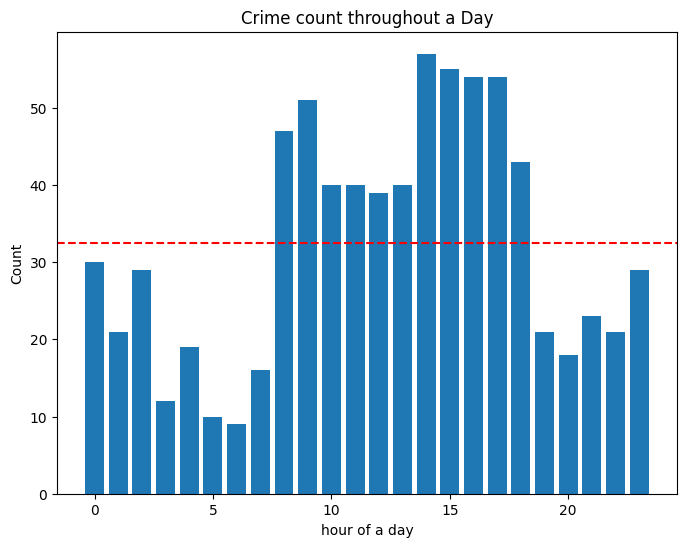

In [11]:
crimes_near_universities = df
value_counts = crimes_near_universities['hour'].value_counts()

# Create a bar plot (histogram)
plt.figure(figsize=(8, 6))
plt.bar(value_counts.index, value_counts.values)

mean_value = value_counts.mean()
plt.axhline(y=mean_value, color='red', linestyle='--', label='Mean')

# Adding labels and title
plt.xlabel('hour of a day')
plt.ylabel('Count')
plt.title('Crime count throughout a Day')

# Show the plot
plt.show()

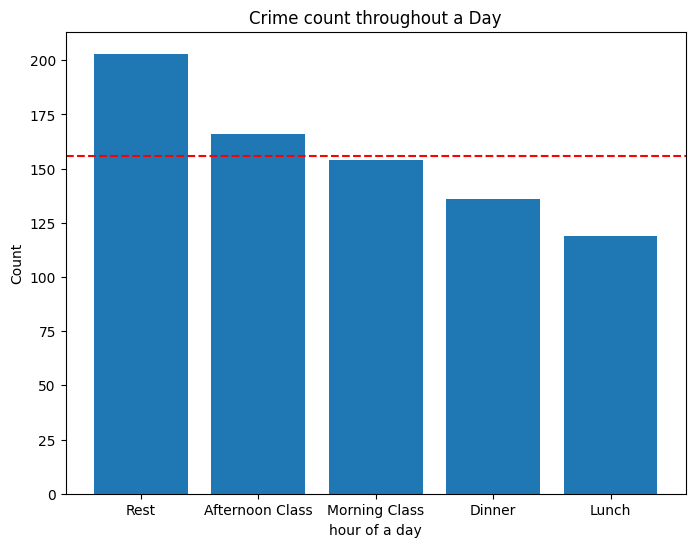

In [12]:
value_counts = crimes_near_universities['TimeOfDay'].value_counts()

# Create a bar plot (histogram)
plt.figure(figsize=(8, 6))
plt.bar(value_counts.index, value_counts.values)

mean_value = value_counts.mean()
plt.axhline(y=mean_value, color='red', linestyle='--', label='Mean')

# Adding labels and title
plt.xlabel('hour of a day')
plt.ylabel('Count')
plt.title('Crime count throughout a Day')

# Show the plot
plt.show()

In [13]:
a = crimes_near_universities.groupby('TimeOfDay').size()
a = a/a.sum() * 100
a = a.reset_index(name = 'Count')

fig = px.line(a, x="TimeOfDay", y="Count")

fig.update_layout(
    title='Distribution of Crime Categories by Time of Day(%)',
    xaxis_title='Day of Week',
    yaxis_title='Percentage (%)',
    xaxis_tickangle= -60
)

fig.show()


# Time and Category

In [14]:
occurrences = crimes_near_universities.groupby(["hour", "Incident Category"]).size().reset_index(name="Occurrences")

# Create a scatter plot with varying dot sizes
fig = px.scatter(occurrences, x="hour", y="Incident Category", size="Occurrences")

fig.show()


# Holiday

In [15]:
occurrences = crimes_near_universities.groupby(["IsHoliday"]).size().reset_index(name="Occurrences")

fig = px.pie(occurrences, values='Occurrences', names='IsHoliday')
fig.show()

- SF: 2.47%
- Denver: 2.44%

too insignificant so drop

In [16]:
crimes_near_universities.drop('IsHoliday', axis=1, inplace=True)

# School day

In [17]:
occurrences = crimes_near_universities.groupby(["IsSchoolDay"]).size().reset_index(name="Occurrences")

fig = px.pie(occurrences, values='Occurrences', names='IsSchoolDay')
fig.show()

Similar to SF of 30.6%

In [18]:
occurrences = crimes_near_universities.groupby(["Incident Category", 'IsSchoolDay']).size().reset_index(name="Occurrences")

# Create a scatter plot with varying dot sizes
fig = px.scatter(occurrences, x="IsSchoolDay", y="Incident Category", size="Occurrences")

fig.show()

# Weekend

In [19]:
occurrences = crimes_near_universities.groupby(["IsWeekend"]).size().reset_index(name="Occurrences")

fig = px.pie(occurrences, values='Occurrences', names='IsWeekend')
fig.show()

SF more at 25%

In [20]:
occurrences = crimes_near_universities.groupby(["Incident Category", "IsWeekend", 'IsSchoolDay']).size().reset_index(name="Occurrences")

# Create a scatter plot with varying dot sizes
fig = px.scatter(occurrences, x="IsWeekend", y="Incident Category", size="Occurrences", color='IsSchoolDay')

fig.show()

# Category and Day of Week

In [21]:
occurrences = crimes_near_universities.groupby(["dayOfWeek"]).size().reset_index(name="Occurrences")

fig = px.pie(occurrences, values='Occurrences', names='dayOfWeek')
fig.show()

In [22]:
occurrences = crimes_near_universities.groupby(["Incident Category", "dayOfWeek"]).size().reset_index(name="Occurrences")

# Create a scatter plot with varying dot sizes
fig = px.scatter(occurrences, x="dayOfWeek", y="Incident Category", size="Occurrences")

fig.show()

In [23]:
occurrences = crimes_near_universities.groupby(["dayOfWeek"]).size().reset_index(name="Occurrences")

day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Create a bar chart with the specified order
fig = px.bar(
    occurrences,
    x="dayOfWeek",
    y="Occurrences",
    category_orders={"dayOfWeek": day_order},
    title='Occurrences by Day of Week',
)

fig.show()

In [24]:
crimes_near_universities['DayOfWeek_num'] = crimes_near_universities['datetime'].dt.day_of_week
near_uni_counts = crimes_near_universities['DayOfWeek_num'].value_counts(normalize = True) * 100

df = pd.DataFrame({'Near Universities': near_uni_counts}).reset_index()
df.rename(columns={'index': 'DayOfWeek'}, inplace=True)
df.sort_values('DayOfWeek', inplace=True)
# days_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
# df['DayOfWeek'] = pd.Categorical(df['DayOfWeek'], categories=days_order, ordered=True)
# df = df.sort_values(by='DayOfWeek')

def int_to_day_name(int_value):
    day_names = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
    return day_names[int_value]

# Apply the function to the DataFrame column
df['DayOfWeek'] = df['DayOfWeek'].apply(int_to_day_name)

fig = go.Figure()

fig = px.line(df, x="DayOfWeek", y="Near Universities")


fig.update_layout(
    title='Distribution of Crime Categories by Day of Week(%)',
    xaxis_title='Day of Week',
    yaxis_title='Percentage (%)',
    # barmode='group',
    xaxis_tickangle= -60
)

fig.show()

# Category

In [25]:
occurrences = crimes_near_universities.groupby(["Incident Category"]).size().reset_index(name="Occurrences")

fig = px.pie(occurrences, values='Occurrences', names='Incident Category')
fig.show()

# K-Means clustering with every feature

In [26]:
from sklearn.cluster import KMeans
import numpy as np
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

def Kmeans_ParameterTesting(data, max_k, num_init, num_iter):
# A list holds the SSE values for each k
    sse = []
    silhouette_coefficients = []
    for k in range(2, max_k):
        kmeans = KMeans(n_clusters=k, n_init=num_init, max_iter=num_iter)
        kmeans.fit(data)
        sse.append(kmeans.inertia_)
        score = silhouette_score(data, kmeans.labels_)
        silhouette_coefficients.append(score)

    plt.style.use("seaborn")
    plt.plot(range(2, max_k), sse)
    plt.xlabel("Number of Clusters")
    plt.ylabel("SSE")
    plt.show()

    plt.style.use("seaborn")
    plt.plot(range(2, max_k), silhouette_coefficients)
    plt.xlabel("Number of Clusters")
    plt.ylabel("Silhouette Coefficient")
    plt.show()

In [27]:
df_cluster = pd.get_dummies(crimes_near_universities, columns=['Incident Category', 'IsWeekend', 'IsSchoolDay', 'dayOfWeek'])
# corr = df_cluster.corr()
# corr[abs(corr)>0.5].count()
display(df_cluster.shape)
df_cluster.head(n=1)

(778, 38)

,offense_id,datetime,offense_code,offense_type_id,geo_lon,geo_lat,date,year,hour,TimeOfDay,month,day,DayOfWeek_num,Incident Category_Trespassing,Incident Category_aggravated-assault,Incident Category_all-other-crimes,Incident Category_arson,Incident Category_auto-theft,Incident Category_burglary,Incident Category_drug-alcohol,Incident Category_larceny,Incident Category_other-crimes-against-persons,Incident Category_public-disorder,Incident Category_robbery,Incident Category_theft-from-motor-vehicle,Incident Category_traffic-accident,Incident Category_white-collar-crime,IsWeekend_False,IsWeekend_True,IsSchoolDay_False,IsSchoolDay_True,dayOfWeek_Friday,dayOfWeek_Monday,dayOfWeek_Saturday,dayOfWeek_Sunday,dayOfWeek_Thursday,dayOfWeek_Tuesday,dayOfWeek_Wednesday
0,2016474748220500,2016-07-26 17:00:00,2205,burglary-business-no-force,-105.004869,39.744035,2016-07-26,2016,17,Dinner,7,31,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0


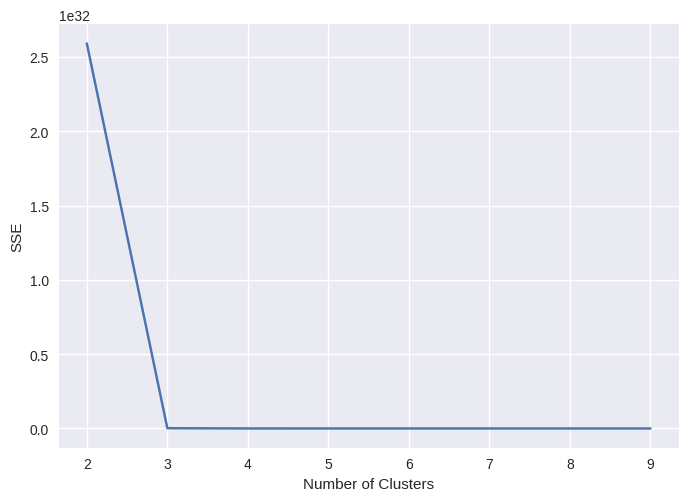

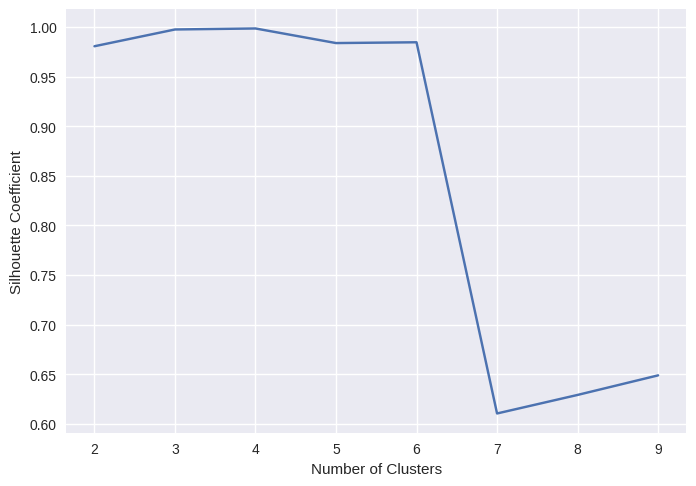

In [28]:
col_to_drop = ['datetime','geo_lon', 'geo_lat', 'date', 'year', 'TimeOfDay', 'offense_type_id', 'offense_code']
Kmeans_ParameterTesting(df_cluster.drop(col_to_drop, axis=1), 10, 20, 50)

## k=3 - useless

In [29]:
final_kmeans = KMeans(n_clusters = 3, max_iter=100, n_init=20)
final_kmeans.fit(df_cluster.drop(col_to_drop, axis=1))

crimes_near_universities['kmeans_label'] = final_kmeans.labels_
display(crimes_near_universities['kmeans_label'].value_counts())

occurrences = crimes_near_universities.groupby(["hour", "Incident Category", 'kmeans_label']).size().reset_index(name="Occurrences")
occurrences.sort_values('kmeans_label', inplace=True)
fig = px.scatter(occurrences, x="hour", y="Incident Category", size="Occurrences", size_max=30, color='kmeans_label')
fig.show()

0    658
2     88
1     32
Name: kmeans_label, dtype: int64

In [30]:
occurrences = crimes_near_universities.groupby(["hour", "IsSchoolDay", 'kmeans_label']).size().reset_index(name="Occurrences")
occurrences.sort_values('kmeans_label', inplace=True)
fig = px.scatter(occurrences, x="hour", y="IsSchoolDay", size="Occurrences", size_max=30, color='kmeans_label')
fig.update_layout(height=800)
fig.show()

In [31]:
occurrences = crimes_near_universities.groupby(["hour", "IsWeekend", 'kmeans_label']).size().reset_index(name="Occurrences")


fig = px.bar(occurrences[occurrences['IsWeekend']==True], x="hour", y="Occurrences", color='kmeans_label', title='Crime Occurrences on a Weekend')
fig.show()
fig = px.bar(occurrences[occurrences['IsWeekend']==False], x="hour", y="Occurrences", color='kmeans_label', title='Crime Occurrences on a Weekday')
fig.show()

In [32]:
occurrences = crimes_near_universities[crimes_near_universities['IsSchoolDay']==True].groupby(["hour", "IsWeekend", 'kmeans_label']).size().reset_index(name="Occurrences")


fig = px.bar(occurrences[occurrences['IsWeekend']==True], x="hour", y="Occurrences", color='kmeans_label', title='Crime Occurrences on a School Weekend')
fig.show()
fig = px.bar(occurrences[occurrences['IsWeekend']==False], x="hour", y="Occurrences", color='kmeans_label', title='Crime Occurrences on a School Weekday')
fig.show()

In [33]:
occurrences = crimes_near_universities[crimes_near_universities['IsSchoolDay']==False].groupby(["hour", "IsWeekend", 'kmeans_label']).size().reset_index(name="Occurrences")


fig = px.bar(occurrences[occurrences['IsWeekend']==True], x="hour", y="Occurrences", color='kmeans_label', title='Crime Occurrences on a Non-School Weekend')
fig.show()
fig = px.bar(occurrences[occurrences['IsWeekend']==False], x="hour", y="Occurrences", color='kmeans_label', title='Crime Occurrences on a Non-School Weekday')
fig.show()

In [34]:
occurrences = crimes_near_universities.groupby(["Incident Category", "dayOfWeek", 'kmeans_label']).size().reset_index(name="Occurrences")

occurrences.sort_values('kmeans_label', inplace=True)
fig = px.scatter(occurrences, x="dayOfWeek", y="Incident Category", size="Occurrences",size_max=30, color='kmeans_label')
fig.show()

## k=6 - useless

In [35]:
final_kmeans = KMeans(n_clusters = 6, max_iter=100, n_init=20)
final_kmeans.fit(df_cluster.drop(col_to_drop, axis=1))

crimes_near_universities['kmeans_label6'] = final_kmeans.labels_
display(crimes_near_universities['kmeans_label6'].value_counts())

occurrences = crimes_near_universities.groupby(["hour", "Incident Category", 'kmeans_label6']).size().reset_index(name="Occurrences")
occurrences.sort_values('kmeans_label6', inplace=True)
fig = px.scatter(occurrences, x="hour", y="Incident Category", size="Occurrences", size_max=30, color='kmeans_label6')
fig.show()

2    658
0     83
4     18
1     11
3      5
5      3
Name: kmeans_label6, dtype: int64

# School Semester Analysis

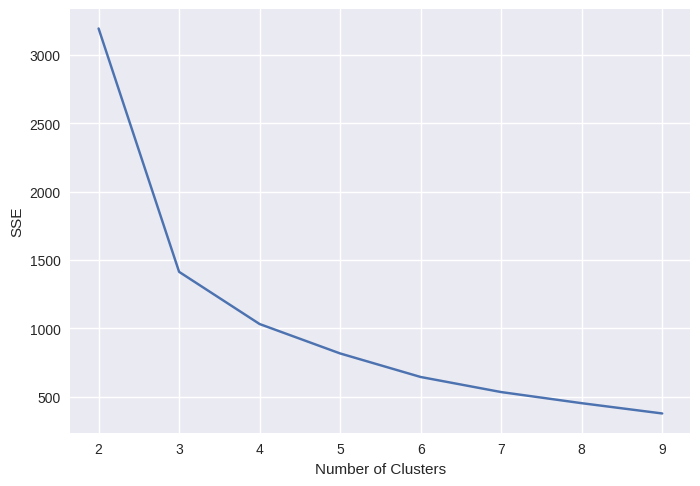

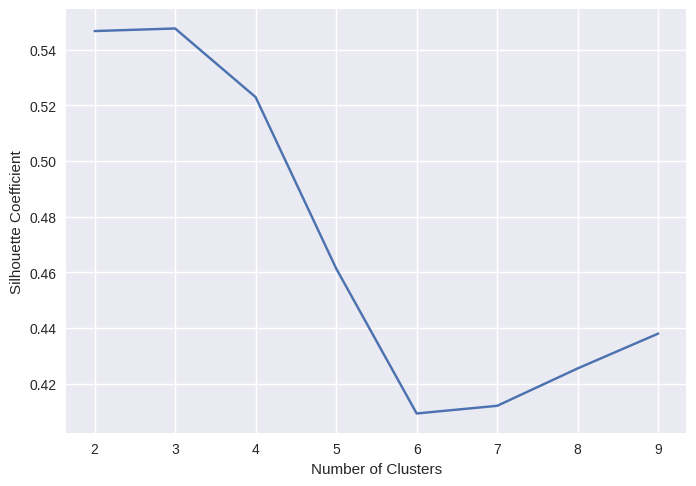

In [36]:
df_school = crimes_near_universities[(crimes_near_universities['IsSchoolDay']==True)].groupby(["hour", 'IsWeekend']).size().reset_index(name="Occurrences")
Kmeans_ParameterTesting(pd.get_dummies(df_school, columns=['IsWeekend']), 10, 20, 50)

## K-Means: k=3

In [37]:
final_kmeans = KMeans(n_clusters = 3, max_iter=100, n_init=20, random_state=2023)
final_kmeans.fit(pd.get_dummies(df_school, columns=['IsWeekend']))

df_school['kmeans_label'] = final_kmeans.labels_
df_school['kmeans_label'].value_counts()

2    18
0    17
1    11
Name: kmeans_label, dtype: int64

In [38]:
fig = px.bar(df_school[df_school['IsWeekend']==True], x="hour", y="Occurrences", color='kmeans_label', title='Crime Occurrences on a Weekend in a Semester')
fig.show()
fig = px.bar(df_school[df_school['IsWeekend']==False], x="hour", y="Occurrences", color='kmeans_label', title='Crime Occurrences on a Weekday in a Semester')
fig.show()

## K-Means: k=4

In [39]:
final_kmeans = KMeans(n_clusters = 4, max_iter=100, n_init=20, random_state=2023)
final_kmeans.fit(pd.get_dummies(df_school, columns=['IsWeekend']))

df_school['kmeans_label4'] = final_kmeans.labels_
df_school['kmeans_label4'].value_counts()

2    18
1    11
0    10
3     7
Name: kmeans_label4, dtype: int64

In [40]:
fig = px.bar(df_school[df_school['IsWeekend']==True], x="hour", y="Occurrences", color='kmeans_label4', title='Crime Occurrences on a Weekend in a Semester')
fig.show()
fig = px.bar(df_school[df_school['IsWeekend']==False], x="hour", y="Occurrences", color='kmeans_label4', title='Crime Occurrences on a Weekday in a Semester')
fig.show()

- for both k=3 and k=4
    - clusters seems to agree to segregate weekday ours into 0000-0759, 0800-1859, 1900-2359

- in comparison to SF which suggests high levels from 0800-2059 or 0800-0059 the next day:
  - share similar peaks to 0800-1859, which is completely expected

- for weekends, cant seem to agree on suitable shifts as crime levels are errative throughout the day


## Hypothesis Testing for Weekday shift - 0800-2859

In [41]:
df_school_weekday = df_school[df_school['IsWeekend']==False]
display(shapiro(df_school_weekday['Occurrences']))

ShapiroResult(statistic=0.9208876490592957, pvalue=0.061109986156225204)

Since the p-value >0.05, we reject the null hypothesis. We do not have sufficient evidence to say that the sample data does not come from a normal distribution.

In [42]:
df_day = df_school_weekday[df_school_weekday['hour'].isin(list(range(8,19)))]['Occurrences'].values
df_nonDay = df_school_weekday[df_school_weekday['hour'].isin(list(range(8,19)))==False]['Occurrences'].values

#Levene's test centered at the mean
display(stats.levene(df_day, df_nonDay, center='mean'))

LeveneResult(statistic=0.9147632972057741, pvalue=0.34924657983262375)

the p-value >0.05. This means we fail to reject the null hypothesis. This means we do not have sufficient evidence to say that the variance in crime occuring during the two periods are significantly different.

In [43]:
stats.ttest_ind(df_day, df_nonDay, equal_var=True, alternative='greater')

TtestResult(statistic=10.912435687457558, pvalue=1.2044223554825606e-10, df=22.0)

Since the p-value <0.05, we reject the null hypothesis. This means we do have sufficient evidence to say that the mean of crimes committed during active hours is greater than mean of crimes committed during non-active hours.

# Non-School Analysis

In [44]:
df_NonSchool = crimes_near_universities[(crimes_near_universities['IsSchoolDay']==False)].groupby(["hour", 'IsWeekend']).size().reset_index(name="Occurrences")
df_NonSchool['Occurrences'].sum()

219

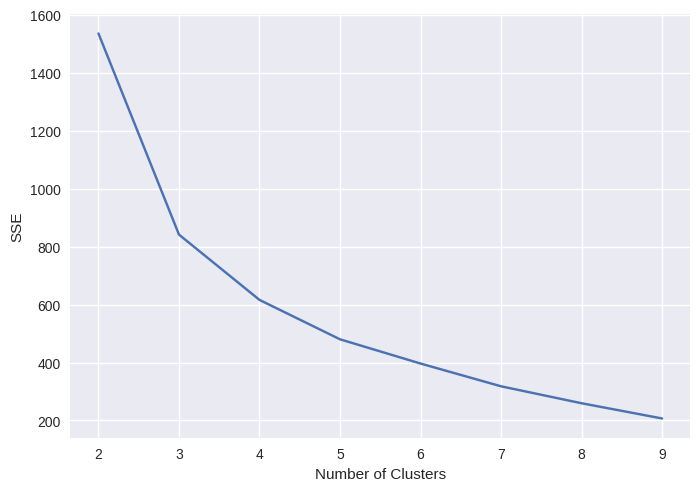

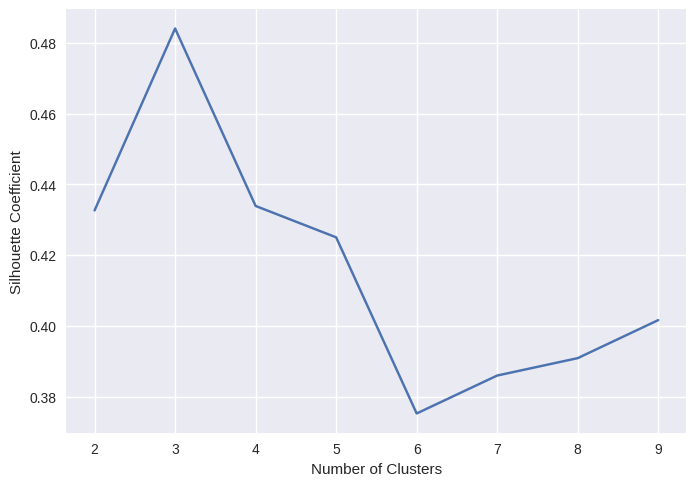

In [45]:
df_NonSchool = crimes_near_universities[(crimes_near_universities['IsSchoolDay']==False)].groupby(["hour", 'IsWeekend']).size().reset_index(name="Occurrences")
Kmeans_ParameterTesting(pd.get_dummies(df_NonSchool, columns=['IsWeekend']), 10, 20, 50)

## K-Means: k=3

In [46]:
final_kmeans = KMeans(n_clusters = 3, max_iter=100, n_init=20, random_state=2023)
final_kmeans.fit(pd.get_dummies(df_NonSchool, columns=['IsWeekend']))

df_NonSchool['kmeans_label'] = final_kmeans.labels_
df_NonSchool['kmeans_label'].value_counts()

2    16
1    15
0    11
Name: kmeans_label, dtype: int64

In [47]:
fig = px.bar(df_NonSchool[df_NonSchool['IsWeekend']==True], x="hour", y="Occurrences", color='kmeans_label', title='Crime Occurrence on a Non-Semester Weekend')
fig.show()
fig = px.bar(df_NonSchool[df_NonSchool['IsWeekend']==False], x="hour", y="Occurrences", color='kmeans_label', title='Crime Occurrence on a Non-Semester Weekday')
fig.show()

In [48]:
fig = px.bar(df_school[df_school['IsWeekend']==True], x="hour", y="Occurrences", color='kmeans_label', title='Crime Occurrence on a Semester Weekday')
fig.show()
fig = px.bar(df_NonSchool[df_NonSchool['IsWeekend']==True], x="hour", y="Occurrences", color='kmeans_label', title='Crime Occurrence on a Non-Semester Weekday')
fig.show()

In [49]:
fig = px.bar(df_school[df_school['IsWeekend']==False], x="hour", y="Occurrences", color='kmeans_label', title='Crime Occurrence on a Semester Weekend')
fig.show()
fig = px.bar(df_NonSchool[df_NonSchool['IsWeekend']==False], x="hour", y="Occurrences", color='kmeans_label', title='Crime Occurrence on a Non-Semester Weekend')
fig.show()

Crime levels share very similar patterns regardless of school or non-school period
  - suggesting perhaps IsSchoolDay is not a very insightful feature

## Hypothesis Testing for Weekday Shift - 0800-1859

In [50]:
df_NonSchool_weekday = df_NonSchool[df_NonSchool['IsWeekend']==False]
display(shapiro(df_NonSchool_weekday['Occurrences']))

ShapiroResult(statistic=0.932862401008606, pvalue=0.14075064659118652)

Since the p-value >0.05, we reject the null hypothesis. We do not have sufficient evidence to say that the sample data does not come from a normal distribution.

In [51]:
df_day = df_NonSchool_weekday[df_NonSchool_weekday['hour'].isin(list(range(8,19)))]['Occurrences'].values
df_nonDay = df_NonSchool_weekday[df_NonSchool_weekday['hour'].isin(list(range(8,19)))==False]['Occurrences'].values

#Levene's test centered at the mean
display(stats.levene(df_day, df_nonDay, center='mean'))

LeveneResult(statistic=1.3724303670533715, pvalue=0.2551627399768871)

the p-value >0.05. This means we reject the null hypothesis. This means we do not have sufficient evidence to say that the variance in crime occuring during the 2 periods are significantly different.

In [52]:
stats.ttest_ind(df_day, df_nonDay, equal_var=True, alternative='greater')

TtestResult(statistic=4.48281569786136, pvalue=0.00011385428517200596, df=20.0)

Since the p-value <0.05, we reject the null hypothesis. This means we do have sufficient evidence to say that the mean of crimes committed during day time is greater than mean of crimes committed during night time on weekdays.

# Category Analysis - too little counts to split into dayOfWeek or School/non-school day

In [53]:
occurrences = crimes_near_universities[crimes_near_universities['IsSchoolDay']==True].groupby(["Incident Category"]).size().reset_index(name="Occurrences")

fig = px.pie(occurrences, values='Occurrences', names='Incident Category', title='Categories of crime during School')
fig.show()

In [54]:
occurrences = crimes_near_universities[crimes_near_universities['IsSchoolDay']==False].groupby(["Incident Category"]).size().reset_index(name="Occurrences")

fig = px.pie(occurrences, values='Occurrences', names='Incident Category', title='Categories of crime during Non-School')
fig.show()

- same proportions of crime during school and non-school periods
- Larceny is the most common crimes, similar to SF
- Traffic incidents although 2nd most common, did not occur in 2018-2023 (not sure why)

## Larceny

In [55]:
df_theft = crimes_near_universities[(crimes_near_universities['Incident Category']=='larceny')].groupby(["hour", 'IsWeekend']).size().reset_index(name="Occurrences")
df_theft.head()

,hour,IsWeekend,Occurrences
0,0,False,4
1,2,False,1
2,3,False,1
3,6,False,2
4,7,False,3


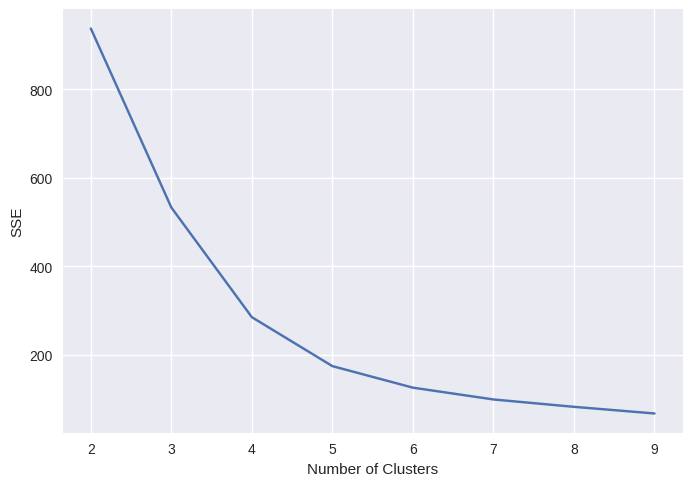

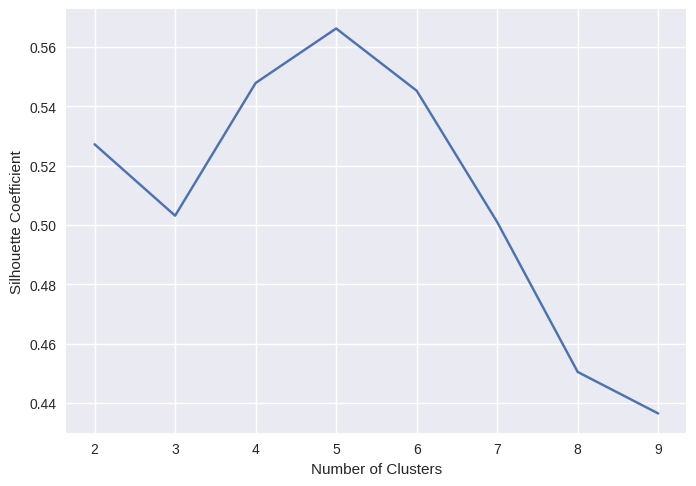

In [56]:
# col_to_drop = ['datetime','geo_lon', 'geo_lat', 'date', 'year', 'TimeOfDay', 'offense_type_id', 'offense_code']
Kmeans_ParameterTesting(pd.get_dummies(df_theft, columns=['IsWeekend']), 10, 20, 50)

### K-Means: k=5

In [57]:
final_kmeans = KMeans(n_clusters = 3, max_iter=100, n_init=20, random_state=2023)
final_kmeans.fit(pd.get_dummies(df_theft, columns=['IsWeekend']))

df_theft['kmeans_label'] = final_kmeans.labels_
df_theft['kmeans_label'].value_counts()

1    11
2    10
0     6
Name: kmeans_label, dtype: int64

In [58]:
fig = px.bar(df_theft[(df_theft['IsWeekend']==False)], x="hour", y="Occurrences",
             color='kmeans_label',
             height=400,  title='Larceny Theft on Weekdays')
fig.show()

fig = px.bar(df_theft[(df_theft['IsWeekend']==True)], x="hour", y="Occurrences",
             color='kmeans_label',
             height=400, title='Larceny Theft on Weekends')
fig.show()

Larceny levels follows the overall pattern of crime levels
- consistently high levels on weekday 0800-1859
- weekend seems merely clsutered by hour and counts too low

### Hypothesis Testing for Larceny on Weekdays - 0800-1859

In [72]:
df_theft_weekday = df_theft[df_theft['IsWeekend']==False]
display(shapiro(df_theft_weekday['Occurrences']))

ShapiroResult(statistic=0.8825974464416504, pvalue=0.028873221948742867)

Since the p-value <0.05, we fail reject the null hypothesis. We do have sufficient evidence to say that the sample data does not come from a normal distribution.

In [73]:
df_theft_day = df_theft_weekday[df_theft_weekday['hour'].isin(list(range(8,19)))]['Occurrences'].values
df_theft_nonDay = df_theft_weekday[df_theft_weekday['hour'].isin(list(range(8,19)))==False]['Occurrences'].values

stats.mannwhitneyu(df_theft_day, df_theft_nonDay, alternative='greater')

MannwhitneyuResult(statistic=77.0, pvalue=0.0002706592257705803)

As p-value < 0.05, we reject null hypothesis that mean of crimes committed during the 2 periods of he day are the same. Hence, we can statistically prove that mean of occurence of Larceny is higher during the day for weekdays.

## Traffic accidents

In [59]:
df_traffic = crimes_near_universities[(crimes_near_universities['Incident Category']=='traffic-accident')].groupby(["hour", 'IsWeekend']).size().reset_index(name="Occurrences")
df_traffic.head()

,hour,IsWeekend,Occurrences
0,0,True,1
1,1,False,2
2,1,True,2
3,2,False,1
4,2,True,2


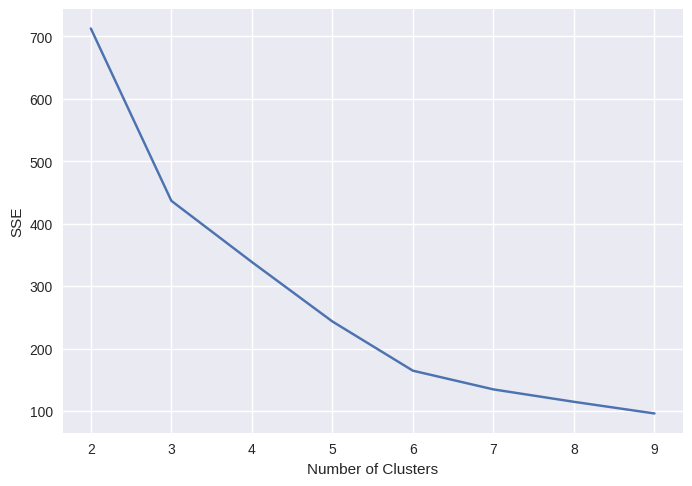

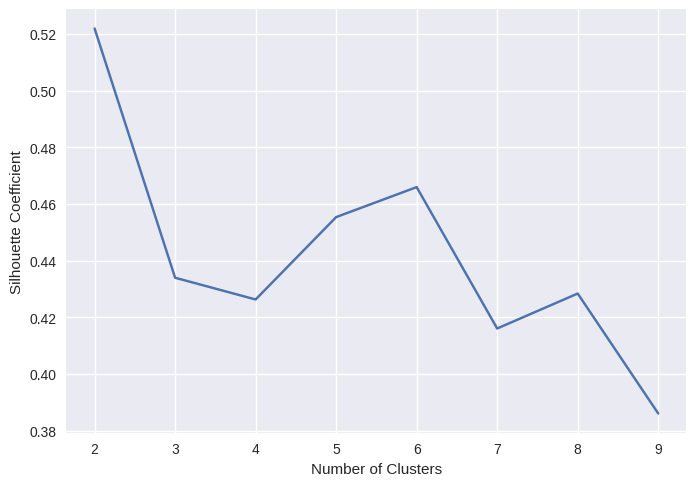

In [60]:
Kmeans_ParameterTesting(pd.get_dummies(df_traffic, columns=['IsWeekend']), 10, 20, 50)

### K-Means: k=6

In [61]:
final_kmeans = KMeans(n_clusters = 6, max_iter=100, n_init=20, random_state=2023)
final_kmeans.fit(pd.get_dummies(df_traffic, columns=['IsWeekend']))

df_traffic['kmeans_label'] = final_kmeans.labels_
df_traffic['kmeans_label'].value_counts()

1    11
0     9
2     7
4     6
3     4
5     3
Name: kmeans_label, dtype: int64

In [62]:
fig = px.bar(df_traffic[(df_traffic['IsWeekend']==False)], x="hour", y="Occurrences",
             color='kmeans_label',
             height=500,  title='Traffic Accidents on Weekdays')
fig.show()

fig = px.bar(df_traffic[(df_traffic['IsWeekend']==True)], x="hour", y="Occurrences",
             color='kmeans_label',
             height=500, title='Traffic Accidents on Weekends')
fig.show()

- on weekday, pattern follows overall crime levels - high levels from 0800-1859
- weekend counts are too little, also merely clustered based on hour

### Hypothesis Testing for Traffic accidents on Weekdays - 0800-1859

In [74]:
df_traffic_weekday = df_traffic[df_traffic['IsWeekend']==False]
display(shapiro(df_traffic_weekday['Occurrences']))

ShapiroResult(statistic=0.9071845412254333, pvalue=0.04148903489112854)

Since the p-value <0.05, we fail reject the null hypothesis. We do have sufficient evidence to say that the sample data does not come from a normal distribution.

In [75]:
df_traffic_day = df_traffic_weekday[df_traffic_weekday['hour'].isin(list(range(8,19)))]['Occurrences'].values
df_traffic_nonDay = df_traffic_weekday[df_traffic_weekday['hour'].isin(list(range(8,19)))==False]['Occurrences'].values

stats.mannwhitneyu(df_traffic_day, df_traffic_nonDay, alternative='greater')

MannwhitneyuResult(statistic=104.5, pvalue=0.0018249771243120027)

As p-value < 0.05, we reject null hypothesis that mean of crimes committed during the 2 periods of he day are the same. Hence, we can statistically prove that mean of occurence of traffic accidents is higher during the day for weekdays.

### Hypothesis Testing for Traffic-accidents - 0800-1059, 1600-1859

In [76]:
df_traffic_peak = df_traffic_weekday[df_traffic_weekday['hour'].isin([8,9,10,16,17,18])]['Occurrences'].values
df_traffic_nonPeak = df_traffic_weekday[df_traffic_weekday['hour'].isin([8,9,10,16,17,18])==False]['Occurrences'].values

stats.mannwhitneyu(df_traffic_peak, df_traffic_nonPeak, alternative='greater')

MannwhitneyuResult(statistic=91.5, pvalue=0.0006275624314273276)

As p-value < 0.05, we reject null hypothesis that mean of crimes committed during the 2 periods of he day are the same. Hence, we can statistically prove that mean of occurence of traffic accidents is higher when people arrive at the school and leave from school for weekdays.

# Time Series Analysis

In [63]:
crimes_near_universities['weekOfYear'] = crimes_near_universities['datetime'].dt.week

In [64]:
occurrence = crimes_near_universities.groupby(['weekOfYear', 'IsSchoolDay']).size().reset_index(name="Occurrences")
occurrence.sort_values('weekOfYear', inplace=True)
fig = px.bar(occurrence, x="weekOfYear", y="Occurrences",
            #  color='kmeans_label',
             height=600, title='Crime levels based on week of theyear', color='IsSchoolDay')
fig.show()

In [65]:
occurrence = crimes_near_universities.groupby(['month']).size().reset_index(name="Occurrences")
occurrence.sort_values('month', inplace=True)
fig = px.bar(occurrence, x="month", y="Occurrences",
            #  color='kmeans_label',
             height=400, title='Crime levels based on Month')
fig.show()

In [66]:
df_time = crimes_near_universities.groupby(['year', 'weekOfYear', 'IsSchoolDay']).size().reset_index(name="Occurrences")
df_time.sort_values('IsSchoolDay', inplace=True)

for year in df_time['year'].unique():
  fig = px.bar(df_time[df_time['year']==year], x='weekOfYear', y="Occurrences", color=df_time[df_time['year']==year]['IsSchoolDay'])
  fig.update_layout(width=1000, title_text='{}'.format(year))
  # fig.update_xaxes(tickvals=df_time[df_time['year']==year]['date'].dt.year, ticktext=df_time[df_time['dayOfWeek']==df_time]['date'].dt.year)

  fig.show()

In [67]:
df_time.corr()

,year,weekOfYear,IsSchoolDay,Occurrences
year,1.000000,-0.049236,0.059031,-0.228061
weekOfYear,-0.049236,1.000000,-0.093182,0.065682
IsSchoolDay,0.059031,-0.093182,1.000000,0.076263
Occurrences,-0.228061,0.065682,0.076263,1.000000


In [68]:
occurrences = crimes_near_universities.groupby(["TimeOfDay"]).size().reset_index(name="Occurrences")

day_order = ['Rest', 'Morning Class', 'Lunch','Afternoon Class', 'Dinner', 'Midnight']

# Create a bar chart with the specified order
fig = px.bar(
    occurrences,
    x="TimeOfDay",
    y="Occurrences",
    category_orders={"TimeOfDay": day_order},
    title='Occurrences by Time of Day',
)

fig.show()

In [69]:
occurrences

,TimeOfDay,Occurrences
0,Afternoon Class,166
1,Dinner,136
2,Lunch,119
3,Morning Class,154
4,Rest,203


In [70]:
# May be interesting to explore these
bins = [0, 6, 12, 18, 21, 24]
labels = ['Midnight', 'Morning', 'Afternoon', 'Evening', 'Night']
crimes_near_universities['TimeOfDay'] = pd.cut(crimes_near_universities['hour'], bins=bins, labels=labels, right=False)

a = crimes_near_universities.groupby('TimeOfDay').size()
a = a/a.sum() * 100
a = a.reset_index(name = 'Count')

fig = px.line(a, x="TimeOfDay", y="Count")

fig.update_layout(
    title='Distribution of Crime Categories by Time of Day(%)',
    xaxis_title='Day of Week',
    yaxis_title='Percentage (%)',
    xaxis_tickangle= -60
)

fig.show()

# Top 20 crimes

In [71]:
occurrences = crimes_near_universities.groupby(["offense_type_id"]).size().reset_index(name="Occurrences")
occurrences['Occurrences'] = occurrences['Occurrences']*100/occurrences['Occurrences'].sum()
occurrences.sort_values('Occurrences', ascending=False ,inplace=True)
occurrences = occurrences[:20]

# Create a bar chart with the specified order
fig = px.bar(
    occurrences,
    x="offense_type_id",
    y="Occurrences",
    title='Top 20 type of crimes',
)

fig.update_layout(xaxis_tickangle= -60)

fig.show()